In [1]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import sklearn
#import skimage.transform
import keras
import itertools
import cv2
import scipy
import os
import csv
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.optimizers import SGD

/opt/conda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/opt/conda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Assign the labels
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}

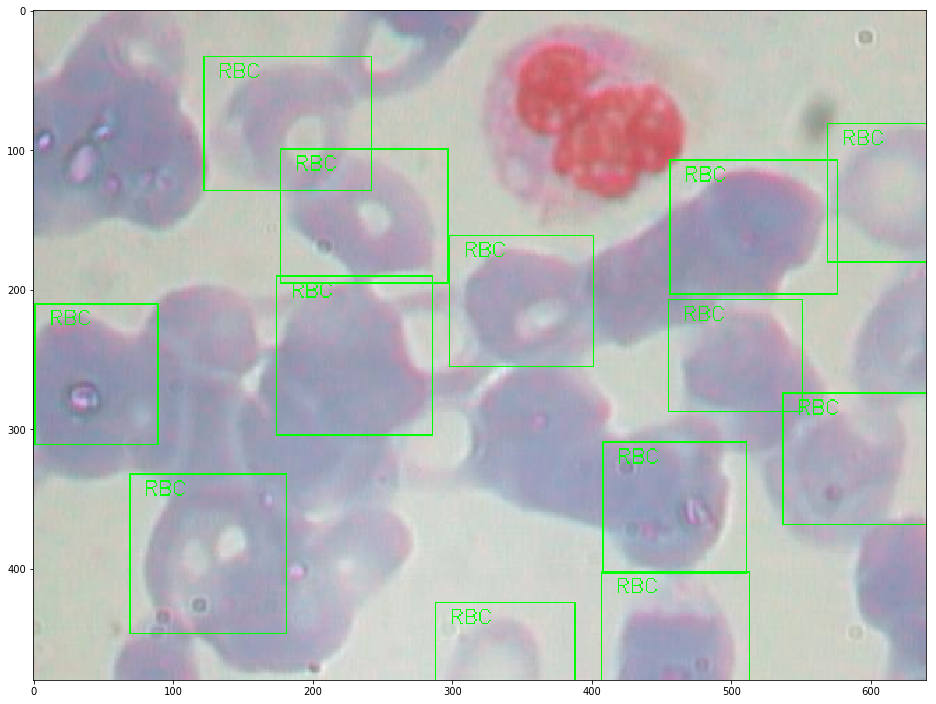

In [3]:
image = cv2.imread("/datasets/ee285s-public/BCCD/dataset-master/JPEGImages/BloodImage_00018.jpg")
tree = ET.parse("/datasets/ee285s-public/BCCD/dataset-master/Annotations/BloodImage_00018.xml")
color = {}
color["R"] = [0, 255, 0]
color["W"] = [0, 0, 255]
color["P"] = [255, 0, 0]
for elem in tree.iter():
    if 'object' in elem.tag or 'part' in elem.tag:
        for attr in list(elem):
            if 'name' in attr.tag:
                name = attr.text
            if 'bndbox' in attr.tag:
                for dim in list(attr):
                    if 'xmin' in dim.tag:
                        xmin = int(round(float(dim.text)))
                    if 'ymin' in dim.tag:
                        ymin = int(round(float(dim.text)))
                    if 'xmax' in dim.tag:
                        xmax = int(round(float(dim.text)))
                    if 'ymax' in dim.tag:
                        ymax = int(round(float(dim.text)))
                cv2.rectangle(image, (xmin, ymin),
                            (xmax, ymax), color[name[0]], 1)
                cv2.putText(image, name, (xmin + 10, ymin + 15),
                        cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], color[name[0]], 1)
plt.figure(figsize=(16,16))
plt.imshow(image)
plt.show()

{'MONOCYTE': 21, 'EOSINOPHIL': 88, 'LYMPHOCYTE': 33, 'NEUTROPHIL': 207, 'BASOPHIL': 3}


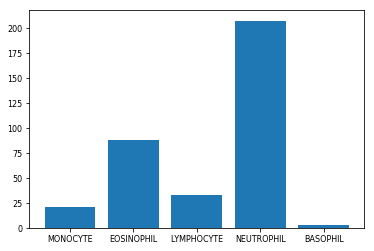

In [4]:
reader = csv.reader(open('/datasets/ee285s-public/BCCD/dataset2-master/labels.csv'))
next(reader)

labels = {
    'BASOPHIL': 0,
    'NEUTROPHIL': 0,
    'EOSINOPHIL': 0,
    'MONOCYTE': 0,
    'LYMPHOCYTE': 0
}
for r in reader:
    curr_label = r[2]
    if len(curr_label) > 0 and len(curr_label) < 11:
        labels[curr_label] += 1
print labels        

plt.bar(range(len(labels)), labels.values(), width = 0.8, align='center')
plt.xticks(range(len(labels)), labels.keys())
plt.tick_params(axis='both', which='major', labelsize=8)
plt.show()

In [5]:
#Since sample size are imbalance for each type, we decide to use the argumented datasets.
label1_dict = {
    'NEUTROPHIL': '0',
    'EOSINOPHIL': '1',
    'MONOCYTE': '2',
    'LYMPHOCYTE': '3'
}

label2_dict = {
    'NEUTROPHIL': '1',
    'EOSINOPHIL': '1',
    'MONOCYTE': '0',
    'LYMPHOCYTE': '0'
}

def load_argumented_images(path):
    data = []
    for t in label1_dict.keys():
        folder = path + '/' + t
        label1 = to_categorical(label1_dict[t], num_classes=4)
        label2 = to_categorical(label2_dict[t], num_classes=2)
        for image_name in os.listdir(folder):
            image = cv2.imread(folder+'/'+image_name)
            if image is not None:
                image = scipy.misc.imresize(arr=image, size=(60, 80, 3))
                img_arr = np.asarray(image)
                img_arr = np.array(img_arr)
                img_arr = img_arr/255.0
                row = [img_arr, label1, label2]
                data.append(row)
            
    return data

In [ ]:
traindata = load_argumented_images('/datasets/ee285s-public/BCCD/dataset2-master/images/TRAIN')
testdata = load_argumented_images('/datasets/ee285s-public/BCCD/dataset2-master/images/TEST')

/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [ ]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve(name):
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.title(name +' Learning Curve')
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_learning_curve(history, name):
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(name +' accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper right')
#     plt.savefig('./'+name+'_accuracy_curve.png')
    # plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(name +' loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper right')
#     plt.savefig('./'+name+'_loss_curve.png')

In [ ]:
def runCNN(train_img, train_label, test_img, test_label, epochs, model, shape, name):
    model.summary() 
    datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images
    history = model.fit_generator(datagen.flow(train_img,train_label, batch_size=32),
                        steps_per_epoch=len(train_img) / 32, epochs=epochs, 
                                  validation_data = [test_img, test_label],
                                  callbacks=[MetricsCheckpoint('logs')])
    evaluate_result = model.evaluate(test_img, test_label, verbose=0)
    print('\nKeras CNN #1C - accuracy:', evaluate_result[1],'\n')
    
    y_pred = model.predict(test_img)
    map_characters = dict_characters
    #print('\n', sklearn.metrics.classification_report(np.where(test_label > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(test_label,axis=1)
    plotKerasLearningCurve(name)
    plt.show()  
    plot_learning_curve(history,name)
    plt.show()

def column(matrix, i):
    a = [row[i] for row in matrix]
    return np.array(a)

In [ ]:
# AlexNet:
def generateAlexNet():
    shape = (60,80,3)
    epochs = 60;
    model = Sequential()
    model.add(Conv2D(96,(11,11),strides=(4,4),input_shape=shape,padding='valid',activation='relu',kernel_initializer='uniform'))  
    model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))  
    model.add(Conv2D(256,(5,5),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))  
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))  
    model.add(Conv2D(384,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))  
    model.add(Conv2D(384,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))  
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))  
    model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))  
    model.add(Flatten())  
    model.add(Dense(4096,activation='relu'))  
    model.add(Dropout(0.5))  
    model.add(Dense(1000,activation='relu'))  
    model.add(Dropout(0.5))  
    model.add(Dense(4,activation='softmax'))  
    model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])
    return model,shape,epochs


def generateVGG():
    shape = (60,80,3)
    epochs = 50
    s = 1
    model = Sequential()  
    #1
    model.add(Conv2D(16, kernel_size=(3,3),activation='relu',
                     input_shape=shape, strides=s))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #2
    model.add(Conv2D(32, kernel_size=(3,3),activation='relu',
                     strides=s))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #3
    model.add(Conv2D(64, kernel_size=(3,3),activation='relu',
                     strides=s))
    model.add(Conv2D(64, kernel_size=(3,3),activation='relu',
                     strides=s))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())  
    model.add(Dense(128,activation='relu'))  
    model.add(Dropout(0.5))  
    model.add(Dense(128,activation='relu'))  
    model.add(Dropout(0.5))  
    model.add(Dense(4,activation='softmax'))  
    model.compile(loss=keras.losses.categorical_crossentropy,
                 optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
    return model,shape,epochs


def generateVGG_sgd():
    shape = (60,80,3)
    model = Sequential()  
    epochs = 100
    s = 1
    #1
    model.add(Conv2D(16, kernel_size=(3,3),activation='relu',
                     input_shape=shape, strides=s))
    #model.add(Conv2D(16, kernel_size=(3,3),activation='relu',
    #                 strides=s))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #2
    #model.add(Conv2D(32, kernel_size=(3,3),activation='relu',
    #                 strides=s))
    model.add(Conv2D(32, kernel_size=(3,3),activation='relu',
                     strides=s))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #3
    model.add(Conv2D(64, kernel_size=(3,3),activation='relu',
                     strides=s))
    model.add(Conv2D(64, kernel_size=(3,3),activation='relu',
                     strides=s))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())  
    model.add(Dense(128,activation='relu'))  
    model.add(Dropout(0.5))  
    model.add(Dense(128,activation='relu'))  
    model.add(Dropout(0.5))  
    model.add(Dense(4,activation='softmax'))
    sgd = keras.optimizers.SGD(lr=0.001, decay=1e-6)
    model.compile(loss= keras.losses.categorical_crossentropy,optimizer=sgd, metrics=['accuracy'])
    return model, shape, epochs

def generate_Custom():
    epochs = 130
    shape = (60,80,3)
    model = Sequential()
    num_classes = 4
    model.add(Conv2D(32, kernel_size = (3,3), strides=(2, 2), padding='same', activation='elu', input_shape=shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.05))
    model.add(Conv2D(64, kernel_size = (3,3), strides=(2, 2), padding='same', activation='elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.15))
    model.add(Conv2D(128, kernel_size = (3,3), strides=(2, 2), padding='same', activation='elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.6))
    model.add(Dense(128, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model, shape, epochs

In [ ]:
[alexNet,shape, epochs] = generateAlexNet()
runCNN(column(traindata, 0), column(traindata,1), column(testdata,0),
      column(testdata,1),epochs, alexNet, shape, "AlexNet");

In [ ]:
[VGGNet, shape, epochs] = generateVGG()
runCNN(column(traindata, 0), column(traindata,1), column(testdata,0),
      column(testdata,1),epochs, VGGNet, shape, "VGG");

In [ ]:
[VGGNetSGD, shape, epochs] = generateVGG_sgd()
runCNN(column(traindata, 0), column(traindata,1), column(testdata,0),
      column(testdata,1),epochs, VGGNetSGD, shape, "VGG");

In [ ]:
[customNet, shape, epochs] = generate_Custom()
runCNN(column(traindata, 0), column(traindata,1), column(testdata,0),
      column(testdata,1),epochs, customNet, shape, "Customized");

In [ ]:
# Run feedfoward network
def runFeedFoward(a,b,c,d,e):
    batch_size = 144
    num_classes = len(b[0])
    epochs = 70
    img_rows, img_cols = 60, 80
    #input_shape = (img_rows, img_cols, 3)
    input_dimension = img_rows * img_cols * 3
    model = Sequential()
    print(input_dimension)
    model.add(Dense(8000, input_dim = input_dimension, init="uniform",activation="relu"))
    model.add(Dense(2000, init="uniform", activation="relu"))
    model.add(Dense(800, init="uniform", activation="relu"))
    model.add(Dense(400, init="uniform", activation="relu"))
    model.add(Dense(100, init="uniform", activation="relu"))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss=keras.losses.categorical_crossentropy, 
                  optimizer=sgd, 
                  metrics=['accuracy'])
    history = model.fit(a, b, nb_epoch=epochs, batch_size=batch_size)
    print("[INFO] evaluating on testing set...")
    (loss, accuracy) = model.evaluate(c, d, batch_size=batch_size, verbose=1)
    print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))
    score = model.evaluate(c,d, verbose=0)
    
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = dict_characters
    #print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1)
    #plotKerasLearningCurve()
    #plt.show()  
    plot_learning_curve(history)
    plt.show()
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()

y_train = column(traindata,1);
y_test = column(testdata, 1);
print(y_train.shape)

X_train = column(traindata,0);
X_test = column(testdata, 0);
new_X_train = X_train.reshape(-1,60*80*3)
new_X_test = X_test.reshape(-1, 60*80*3)
runFeedFoward(new_X_train,y_train,new_X_test,y_test,1)

In [ ]:
# Store the model to disk
model_json = alexNet.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
alexNet.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
evaluate_result = alexNet.evaluate(column(testdata,0), column(testdata,1), verbose=0)
print('\nKeras CNN #1C - accuracy:', evaluate_result[1],'\n')


# Load the model from disk
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

loaded_model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
loaded_model.evaluate(column(testdata,0), column(testdata,1), verbose=0)
print('\nKeras CNN #1C - accuracy:', evaluate_result[1],'\n')